# The Implementation of our Project
# with datasets from CIFAR-10
# using TensorFlow(ML library from Google)

by [Hammani Elasri Elkamali]

#EXECUTION TIME 4 SECOND

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

# Use PrettyTensor to simplify Neural Network construction.
import prettytensor as pt

This was developed using Python 3.5.2 (Anaconda) and TensorFlow version 12 

## Load Data

Load the class-names.

In [2]:
import cifar10

In [3]:
class_names = cifar10.load_class_names()
#type(class_names)
#class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


### Data Dimensions

The data dimensions are used in several places in the source-code below. They have already been defined in the cifar10 module, so we just need to import them.

In [4]:
from cifar10 import img_size, num_channels, num_classes

The images are 32 x 32 pixels, but we will crop the images to 24 x 24 pixels.

In [5]:
img_size_cropped = 24

### Placeholder variables

Placeholder variables serve as the input to the TensorFlow computational graph that we may change each time we execute the graph. We call this feeding the placeholder variables and it is demonstrated further below.

First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional array. The data-type is set to `float32` and the shape is set to `[None, img_size, img_size, num_channels]`, where `None` means that the tensor may hold an arbitrary number of images with each image being `img_size` pixels high and `img_size` pixels wide and with `num_channels` colour channels.

In [6]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable `x`. The shape of this placeholder variable is `[None, num_classes]` which means it may hold an arbitrary number of labels and each label is a vector of length `num_classes` which is 10 in this case.

In [7]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

We could also have a placeholder variable for the class-number, but we will instead calculate it using argmax. Note that this is a TensorFlow operator so nothing is calculated at this point.

In [8]:
y_true_cls = tf.argmax(y_true, dimension=1)

### Helper-function for creating Pre-Processing

The following helper-functions create the part of the TensorFlow computational graph that pre-processes the input images. Nothing is actually calculated at this point, the function merely adds nodes to the computational graph for TensorFlow.

The pre-processing is different for training and testing of the neural network:
* For training, the input images are randomly cropped, randomly flipped horizontally, and the hue, contrast and saturation is adjusted with random values. This artificially inflates the size of the training-set by creating random variations of the original input images. Examples of distorted images are shown further below.

* For testing, the input images are cropped around the centre and nothing else is adjusted.

In [9]:
def pre_process_image(image, training):
    # This function takes a single image as input,
    # and a boolean whether to build the training or testing graph.
    
    if training:
        # For training, add the following to the TensorFlow graph.

        # Randomly crop the input image.
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])

        # Randomly flip the image horizontally.
        image = tf.image.random_flip_left_right(image)
        
        # Randomly adjust hue, contrast and saturation.
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

        # Some of these functions may overflow and result in pixel
        # values beyond the [0, 1] range. It is unclear from the
        # documentation of TensorFlow 0.10.0rc0 whether this is
        # intended. A simple solution is to limit the range.

        # Limit the image pixels between [0, 1] in case of overflow.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        # For training, add the following to the TensorFlow graph.

        # Crop the input image around the centre so it is the same
        # size as images that are randomly cropped during training.
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)

    return image

The function above is called for each image in the input batch using the following function.

In [10]:
def pre_process(images, training):
    # Use TensorFlow to loop over all the input images and call
    # the function above which takes a single image as input.
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)

    return images

In order to plot the distorted images, we create the pre-processing graph for TensorFlow, so we may execute it later.

In [11]:
distorted_images = pre_process(images=x, training=True)

### Helper-function for creating Main Processing

The following helper-function creates the main part of the convolutional neural network. It uses Pretty Tensor which was described in the previous tutorials.

In [12]:
def main_network(images, training):
    # Wrap the input images as a Pretty Tensor object.
    x_pretty = pt.wrap(images)

    # Pretty Tensor uses special numbers to distinguish between
    # the training and testing phases.
    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer

    # Create the convolutional neural network using Pretty Tensor.
    # It is very similar to the previous tutorials, except
    # the use of so-called batch-normalization in the first layer.
    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=64, name='layer_conv1', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=3, depth=64, name='layer_conv2', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=512, name='layer_fc1').\
            fully_connected(size=256, name='layer_fc2').\
            fully_connected(size=128, name='layer_fc3').\
            softmax_classifier(num_classes=num_classes, labels=y_true)

    return y_pred, loss
#(N-F)/S+1 output size!

### Helper-function for creating Neural Network

The following helper-function creates the full neural network, which consists of the pre-processing and main-processing defined above.

Note that the neural network is enclosed in the variable-scope named 'network'. This is because we are actually creating two neural networks in the TensorFlow graph. By assigning a variable-scope like this, we can re-use the variables for the two neural networks, so the variables that are optimized for the training-network are re-used for the other network that is used for testing.

In [13]:
def create_network(training):
    # Wrap the neural network in the scope named 'network'.
    # Create new variables during training, and re-use during testing.
    with tf.variable_scope('network', reuse=not training):
        # Just rename the input placeholder variable for convenience.
        images = x

        # Create TensorFlow graph for pre-processing.
        images = pre_process(images=images, training=training)

        # Create TensorFlow graph for the main processing.
        y_pred, loss = main_network(images=images, training=training)

    return y_pred, loss

### Create Neural Network for Training Phase

First create a TensorFlow variable that keeps track of the number of optimization iterations performed so far. In the previous tutorials this was a Python variable, but in this tutorial we want to save this variable with all the other TensorFlow variables in the checkpoints.

Note that `trainable=False` which means that TensorFlow will not try to optimize this variable.

In [14]:
global_step = tf.Variable(initial_value=0,name='global_step', trainable=False)

Create the neural network to be used for training. The `create_network()` function returns both `y_pred` and `loss`, but we only need the `loss`-function during training.

In [15]:
_, loss = create_network(training=True)

Create an optimizer which will minimize the `loss`-function. Also pass the `global_step` variable to the optimizer so it will be increased by one after each iteration.

### Create Neural Network for Test Phase / Inference

Now create the neural network for the test-phase. Once again the `create_network()` function returns the predicted class-labels `y_pred` for the input images, as well as the `loss`-function to be used during optimization. During testing we only need `y_pred`.

In [16]:
y_pred, _ = create_network(training=False)

We then calculate the predicted class number as an integer. The output of the network `y_pred` is an array with 10 elements. The class number is the index of the largest element in the array.

In [17]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

Then we create a vector of booleans telling us whether the predicted class equals the true class of each image.

The classification accuracy is calculated by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then taking the average of these numbers.

### Saver

In order to save the variables of the neural network, so they can be reloaded quickly without having to train the network again, we now create a so-called Saver-object which is used for storing and retrieving all the variables of the TensorFlow graph. Nothing is actually saved at this point, which will be done further below.

In [18]:
saver = tf.train.Saver()

In [19]:
session = tf.Session()

### Restoring Variables From Checkpoint


In [20]:
#YES
save_dir = 'checkpoints/'

Create the directory if it does not exist.

In [21]:
#YES
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

This is the base-filename for the checkpoints, TensorFlow will append the iteration number, etc.

In [22]:
#YES
save_path = os.path.join(save_dir, 'cifar10_cnn')

First try to restore the latest checkpoint. This may fail and raise an exception e.g. if such a checkpoint does not exist, or if you have changed the TensorFlow graph.

In [23]:
#YES
try:
    print("Trying to restore last checkpoint ...")

    # Use TensorFlow to find the latest checkpoint - if any.
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

Trying to restore last checkpoint ...
Restored checkpoint from: checkpoints/cifar10_cnn-306000


In [24]:
#YES
def predict_cls_test():
    return predict_cls(images = images_test,
                       labels = labels_test,
                       cls_true = cls_test)

# Function for test one image


In [25]:
#YES
def predict_one_image(image):
    #np.set_printoptions(precision=3, suppress=True)
    
    prediction ,indice = session.run([y_pred, y_pred_cls],feed_dict={x: [image]})
    #label_pred, cls_pred = session.run([y_pred, y_pred_cls],feed_dict={x: [img]}
    
    #print(prediction[0])        #show the output tensor in onehot incoded 
    #print(indice[0])            #shows the indice of the predicted class 
    
    return class_names[indice[0]],prediction[0]

In [26]:
#YES
def Show_prediction(Img):
    try:
        np.set_printoptions(precision=3, suppress=True)

        class_name,_vect = predict_one_image(Img)

        plt.rcParams['figure.figsize'] = (4,4)
        plt.title(class_name)

        plt.imshow(myImage)

        plt.rcParams['figure.figsize'] = (1.0,1.0) #for real dimension
        plt.figure()
        plt.title("the real classified image")
        plt.imshow(Img)

        #function img.getbbox() returns picture dimensions

    except ValueError:
        print("There is a problem fix it !!")

In [27]:
#YES

from PIL import Image
#myImage = Image.open("images/dog4.jpg")

def import_resize_predict_image(myImage):
    size32 = (32,32)

    print("the original size :",myImage.getbbox())  #the original size of the image
    original = myImage.copy()
    
    w,h = myImage.size

    if w==h:
        lastImg = myImage.copy()
        lastImg.thumbnail(size32)
        
        #called while we were debugging
            #print("\nwidth EQUAL height\n")
            #print("size after thumbnail",myImage.getbbox())
        #called while we were debugging
    elif w>h:
        lastImg = myImage.crop((0, 0, w,w))
        lastImg.thumbnail((size32))
        
        #called while we were debugging
            #print("\nWidth LARGE\n")
            #print("size after thumbnail",lastImg.getbbox())
            #lastImg.save("images/32Img.jpg")
            #print("myImage :",myImage.getbbox())
            #print("lastImg :",lastImg.getbbox())
        #called while we were debugging
    else:
        lastImg = myImage.crop((0, 0, h,h))
        lastImg.thumbnail((size32))
        
        #called while we were debugging
            #print("\nHeight LARGE\n")
            #print("size after thumbnail",lastImg.getbbox())
            #print("myImage :",myImage.getbbox())
            #print("lastImg :",lastImg.getbbox())
        #called while we were debugging

        
    #plot_originalImg_and_32pImg(original,lastImg)  #just showing the original image next to real clasified image
    Img = np.asarray(lastImg)   #converting the ready for predicition image
    
    print("the size for predicted :",lastImg.getbbox())  #the original size of the image
    Show_prediction(Img)
    #print(Img.shape)
    #print(Img.size)
    #print(Img.dtype)
    #print(type(Img))
    #myImage.resize((32,32),Image.ANTIALIAS).save("voiture1_32.jpg")

the original size : (0, 0, 940, 705)
the size for predicted : (0, 0, 32, 25)


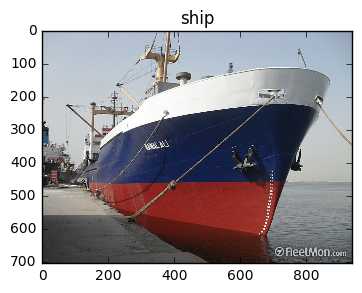

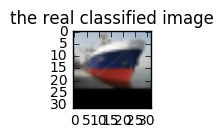

In [28]:
#YES
#img, cls = get_test_image(897)   #this get an image and label from test images from cifar data base 
#print(Img.shape)                 #image shape is knows as (32, 32, 3)

myImage = Image.open("images/ship1.jpg")
import_resize_predict_image(myImage)

#excution time 1 second 


## Close TensorFlow Session

## Conclusion

This tutorial showed how to make a Convolutional Neural Network for classifying images in the CIFAR-10 data-set. The classification accuracy was about 79-80% on the test-set.

The output of the convolutional layers was also plotted, but it was difficult to see how the neural network recognizes and classifies the input images. Better visualization techniques are needed.